### Load Features and Labels

In [2]:
import pandas as pd
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import math

%matplotlib inline

### Load Data
The German Credit bank customer data is used to determine if a particular person is a good or bad credit risk. Thus, credit risk of the customer is the classes you must predict. In this case, the cost to the bank of issuing a loan to a bad risk customer is five times that of denying a loan to a good customer. This fact will become important when evaluating the performance of the model.

In [3]:
Features = np.array(pd.read_csv('Credit_Features.csv'))
Labels = np.array(pd.read_csv('Credit_Labels.csv'))
print(Features.shape)
print(Labels.shape)

(1000, 35)
(1000, 1)


### Construct the logistic regression model

To create a baseline for comparison you will now create a logistic regression model without cross validation. This model uses a fixed set of hyperparameters. You will compare the performance of this model with the cross validation results computed subsequently.


In [4]:
## Randomly sample cases to create independent training and test data
nr.seed(1115)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 300)
X_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
X_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

    Define a logistic regression model object using the LogisticRegression method from the scikit-learn linear_model package
    Fit the linear model using the numpy arrays of the features and the labels for the training data set.

In [5]:
logistic_mod = linear_model.LogisticRegression(C = 1.0, class_weight = {0:0.45, 1:0.55},solver='lbfgs') 
logistic_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight={0: 0.45, 1: 0.55}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

The code in the cell below computes and displays metrics and the ROC curve for the model using the test data subset. Execute this code and examine the results. 

                 Confusion matrix
                 Score positive    Score negative
Actual positive       134                78
Actual negative        18                70

Accuracy        0.68
AUC             0.79
Macro precision 0.68
Macro recall    0.71
 
           Positive      Negative
Num case      212            88
Precision    0.88          0.47
Recall       0.63          0.80
F1           0.74          0.59


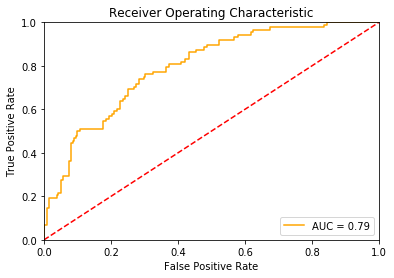

In [6]:
def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])

def print_metrics(labels, probs, threshold):
    scores = score_model(probs, threshold)
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy        %0.2f' % sklm.accuracy_score(labels, scores))
    print('AUC             %0.2f' % sklm.roc_auc_score(labels, probs[:,1]))
    print('Macro precision %0.2f' % float((float(metrics[0][0]) + float(metrics[0][1]))/2.0))
    print('Macro recall    %0.2f' % float((float(metrics[1][0]) + float(metrics[1][1]))/2.0))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])

def plot_auc(labels, probs):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    ## Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()    

probabilities = logistic_mod.predict_proba(X_test)
print_metrics(y_test, probabilities, 0.3)  
plot_auc(y_test, probabilities)

### Cross validate model

To compute a better estimate of model performance, you can perform simple cross validation. The code in the cell performs the following processing:

1.   Create a list of the metrics to be computed for each fold.
2.   Defines a logistic regression model object.
3.   A 10 fold cross validation is performed using the cross_validate function from the scikit-learn model_selection package.








In [7]:
Labels = Labels.reshape(Labels.shape[0],)
scoring = ['precision_macro', 'recall_macro', 'roc_auc']
logistic_mod = linear_model.LogisticRegression(C = 1.0, class_weight = {0:0.45, 1:0.55},solver='lbfgs') 
scores = ms.cross_validate(logistic_mod, Features, Labels, scoring=scoring,
                        cv=10, return_train_score=False)

The code in the cell below displays the performance metrics along with the mean and standard deviation, computed for each fold to the cross validation. The 'macro' versions of precision and recall are used. These macro versions average over the positive and negative cases. 

In [8]:
def print_format(f,x,y,z):
    print('Fold %2d    %4.3f        %4.3f      %4.3f' % (f, x, y, z))

def print_cv(scores):
    fold = [x + 1 for x in range(len(scores['test_precision_macro']))]
    print('         Precision     Recall       AUC')
    [print_format(f,x,y,z) for f,x,y,z in zip(fold, scores['test_precision_macro'], 
                                          scores['test_recall_macro'],
                                          scores['test_roc_auc'])]
    print('-' * 40)
    print('Mean       %4.3f        %4.3f      %4.3f' % 
          (np.mean(scores['test_precision_macro']), np.mean(scores['test_recall_macro']), np.mean(scores['test_roc_auc'])))  
    print('Std        %4.3f        %4.3f      %4.3f' % 
          (np.std(scores['test_precision_macro']), np.std(scores['test_recall_macro']), np.std(scores['test_roc_auc'])))

print_cv(scores)  

         Precision     Recall       AUC
Fold  1    0.741        0.710      0.825
Fold  2    0.727        0.702      0.793
Fold  3    0.687        0.671      0.790
Fold  4    0.620        0.607      0.727
Fold  5    0.788        0.776      0.824
Fold  6    0.727        0.702      0.785
Fold  7    0.604        0.602      0.682
Fold  8    0.739        0.719      0.842
Fold  9    0.700        0.679      0.790
Fold 10    0.647        0.652      0.751
----------------------------------------
Mean       0.698        0.682      0.781
Std        0.056        0.050      0.046


### Optimize hyperparameters with nested cross validation

To start the nested cross validation process it is necessary to define the randomly sampled folds for the inner and outer loops. The code in the cell below uses the KFolds function from the scikit-learn model_selection package to define fold selection objects. Notice that the shuffle = True argument is used in both cases. This argument specifies that a random shuffle is preformed before folds are created, ensuring that the sampling of the folds for the inside and outside loops are independent. Notice that by creating these independent fold objects there is no need to actually create nested loops for this process.

In [9]:
nr.seed(123)
inside = ms.KFold(n_splits=10, shuffle = True)
nr.seed(321)
outside = ms.KFold(n_splits=10, shuffle = True)

The code below uses the inside k-fold object to execute the inside loop of the nested cross validation. Specifically, the steps are:

1.   Define a dictionary with the grid of parameter values to search over. In this case there is only one parameter, C, with a list of values to try. In a more general case, the dictionary can contain values from multiple parameters, creating a multi-dimensional grid that the cross validation process will iterate over. In this case there are 5 hyperparameter values in the grid and 10-fold cross validation is being used. Thus, the model will be trained and evaluated 50 times.
2.  The logistic regression model object is defined.
3.  The cross validation search over the parameter grid is performed using the GridSearch function from the scikit-learn model_selection package. Notice that the cross validation folds are computed using the inside k-fold object.


In [10]:
nr.seed(3456)
## Define the dictionary for the grid search and the model object to search on
param_grid = {"C": [0.1, 1, 10, 100, 1000]}
## Define the logistic regression model
logistic_mod = linear_model.LogisticRegression(class_weight = {0:0.45, 0:0.55},solver='lbfgs') 

## Perform the grid search over the parameters
clf = ms.GridSearchCV(estimator = logistic_mod, param_grid = param_grid, 
                      cv = inside, # Use the inside folds
                      scoring = 'roc_auc',
                      return_train_score = True,n_jobs=-1)

The cross validated grid search object, clf, has been created. 

The code in the cell below fits the cross validated model using the fit method. The AUC for each hyperparameter and fold is displayed as an array. Finally, the hyperparameter for the model with the best average AUC is displayed.

In [11]:
## Fit thhe cross validated grid search over the data 
clf.fit(Features, Labels)
keys = list(clf.cv_results_.keys())
for key in keys[6:16]:
    print(clf.cv_results_[key])
## And print the best parameter value
clf.best_estimator_.C

[0.80157596 0.80621253 0.80685065 0.80690919 0.80695017]
[0.1 1 10 100 1000]
[0.80539063 0.81153846 0.81204928 0.81205529 0.81205529]
[0.79989605 0.8035343  0.80301455 0.8024948  0.80301455]
[0.04924078 0.0479681  0.04892577 0.0501936  0.05031466]
[{'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}]
[0.00812105 0.01209898 0.01500578 0.01088777 0.01463168]
[3.15393233e-03 3.23210645e-03 3.76995491e-05 1.07528984e-03
 1.24034719e-03]
[0.89369242 0.89156627 0.89085755 0.89085755 0.89085755]
[0.00426367 0.00453733 0.00466808 0.00465652 0.00465554]


0.1

The code in the cell below executes the outer loop of the nested cross validation using the cross_val_scores function from the scikit-learn model_selection package. The folds are determined by the outside k-fold object. The mean and standard deviation of the AUC is printed along with the value estimated for each fold. Execute this code and examine the result. 

In [12]:
nr.seed(498)
cv_estimate = ms.cross_val_score(clf, Features, Labels, cv = outside,n_jobs=-1) # Use the outside folds
print('Mean performance metric = %4.3f' % np.mean(cv_estimate))

print('SDT of the metric       = %4.3f' % np.std(cv_estimate))
print('Outcomes by cv fold')
for i, x in enumerate(cv_estimate):
    print('Fold %2d    %4.3f' % (i+1, x))

/home/fernando/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/fernando/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/fernando/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/fernando/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


Mean performance metric = 0.774
SDT of the metric       = 0.037
Outcomes by cv fold
Fold  1    0.782
Fold  2    0.727
Fold  3    0.755
Fold  4    0.754
Fold  5    0.788
Fold  6    0.804
Fold  7    0.728
Fold  8    0.860
Fold  9    0.780
Fold 10    0.766


Now, you will build and test a model using the estimated optimal hyperparameters.

                 Confusion matrix
                 Score positive    Score negative
Actual positive       123                89
Actual negative        15                73

Accuracy        0.65
AUC             0.80
Macro precision 0.67
Macro recall    0.70
 
           Positive      Negative
Num case      212            88
Precision    0.89          0.45
Recall       0.58          0.83
F1           0.70          0.58


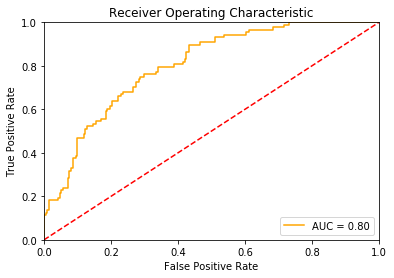

In [13]:
logistic_mod = linear_model.LogisticRegression(C = 0.1, class_weight = {0:0.45, 1:0.55}) 
logistic_mod.fit(X_train, y_train)
probabilities = logistic_mod.predict_proba(X_test)
print_metrics(y_test, probabilities, 0.3)  
plot_auc(y_test, probabilities)